installo librerie mancanti

In [1]:
%%capture
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scikit-misc
    !pip install pytorch-lightning
    !pip install -U matplotlib
    !pip install scanpy
    #!pip install --quiet scvi-tools[tutorials]
    !pip install --quiet gdown
    #!pip install --quiet --upgrade seaborn==0.12
    !pip install --quiet bbknn
    # riavvia il runtime e riesegui tutto

mi muovo nella diectory experiment

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir(r"drive/MyDrive/Colab Notebooks/tirocinio/tirocinio-autoencoder/datasets/dataset1")
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/tirocinio/tirocinio-autoencoder/datasets/dataset1


carico le librerire 

In [155]:
from importlib import reload
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../../autoencoder")
import nn, module, dataset, plot

carico il dataset selezionando:
- il percorso del file,
- la dimensione del batch
- il numero di geni da utilizzare
- la metrica associata ai geni presente nel dataset da usare per selezionare i geni.
- seleziono l'ordine della metrica 
  (se sceglire dal piu piccolo al piu grande o viceversa)
- il tipo di scala da applicare al nostro dataset in input alla rete
- la probabilita di dropout dei geni come data augmentation
- la percentuale di dati di train, validation e di test
- il numero di thread da utilizzare

se voglio accedere ai dati direttamente posso ricavarli con l'attributo adata

In [158]:
reload(dataset)
import dataset
from dataset import CountDataModule
dls = CountDataModule(
        adata_path="dataset1.h5ad.gzip",
        batch_size=128,
        n_gene=3072,
        gene_filter="highly_variable_rank",
        gene_filter_ascending=False,
        scale_type="StandardScaler",
        p_gene_dropout=0.,
        train_val_test_lengths=[0.8, 0.2, 0.0],
        num_workers=4,
)
dls.setup()
dls.adata

c:\Users\guido\Desktop\tesi\model-scvi\ENV\lib\site-packages\torch\utils\data\dataset.py:342: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


AnnData object with n_obs × n_vars = 68579 × 3072
    obs: 'celltype'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'GDI'
    uns: 'celltype_colors', 'hvg'

In [160]:
dls.adata.var[["GDI", "variances_norm"]].corr()

,GDI,variances_norm
GDI,1.000000,0.372943
variances_norm,0.372943,1.000000


posso scegliere se caricare un modello precedentemente addestrato oppure se addestrarne uno nuovo.


Ogni volta che ne addestriamo uno nuovo i parametri della rete vengono salvati 
nel file `./lightining_logs/version_[v]/checkpoints/epoch=[n-step=[s].ckpt`


mentre i parametri del modello vengono salvati nel file `./lightining_logs/version_[v]/hparams.yaml`


In [188]:
reload(module)
import module
from module import AutoencoderNB
autoencoder = AutoencoderNB.load_from_checkpoint(
    "./morandin/lightning_logs/version_0/checkpoints/epoch=19-step=8580.ckpt",
    hparams_file="./morandin/lightning_logs/version_0/hparams.yaml"
    )

FileNotFoundError: [Errno 2] No such file or directory: 'c:/Users/guido/Desktop/tesi/tirocinio/tirocinio-autoencoder/datasets/dataset1/morandin/lightning_logs/version_0/checkpoints/epoch=19-step=8580.ckpt'

In [210]:
reload(module)
import module
from module import AutoencoderNB
torch.manual_seed(1)
autoencoder = AutoencoderNB(
    n_input=dls.adata.n_vars, 
    n_latent=24, 
    layers_dim=[128, 64, 64,], 
    library_layers_dim=[128, 128]
)

logger = pl.loggers.CSVLogger(save_dir="saverio")
trainer = pl.Trainer(accelerator="cpu", devices=1, max_epochs=20, logger=logger)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


### Learning rate optimization.
see documentation [here](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

It is important to not choose the best learning rate but just one in the middle


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at c:\Users\guido\Desktop\tesi\tirocinio\tirocinio-autoencoder\datasets\dataset1\lr_find_temp_model_1188729b-962b-450d-82dd-b4b6e27739e2.ckpt


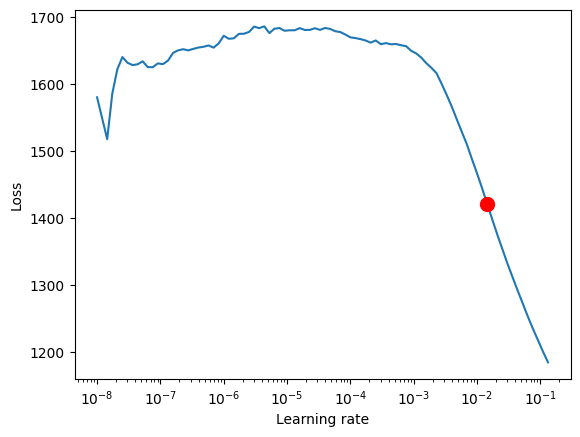

In [211]:
lr_finder = trainer.tuner.lr_find(autoencoder, datamodule=dls)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
autoencoder.hparams.learning_rate = new_lr

In [ ]:
trainer.fit(autoencoder, datamodule=dls)

posso visualizzare come e' avvenuto l'apprendimento confrontandolo con eventuali altri apprendimenti
con questa funzione.

In [26]:
!cp "/content/drive/MyDrive/Colab Notebooks/tirocinio/tirocinio-autoencoder/datasets/dataset1/saverio/notebook2.ipynb" "/content/drive/MyDrive/Colab Notebooks/tirocinio/tirocinio-autoencoder/datasets/dataset1/morandin/notebook.ipynb"

In [ ]:
import plot
reload(plot)
import plot
from plot import plot_CSV_collection, df_yaml_collection

plot_CSV_collection(
    base_dir= "./morandin/lightning_logs/",
)

con questa funzione posso anche visualizzare i parametri che ho utilizzato per allenare il modello
(posso aggiungere tutti i parametri che voglio)

In [18]:
display(df_yaml_collection(
    "./morandin/lightning_logs/",
    hparams_label=["layers_dim", "library_layers_dim", "n_gene", "n_latent", "n_input"]))

,layers_dim,library_layers_dim,n_gene,n_latent,n_input
version,,,,,
version_0,"[128, 64, 64]","[128, 128]",3072.0,24.0,3072.0


Eseguo la predizione su tutti i dati del dataset

In [19]:
logger = pl.loggers.CSVLogger("morandin")
trainer = pl.Trainer(accelerator="cpu", devices=1, max_epochs=20, logger=logger)
predictions = trainer.predict(autoencoder, datamodule=dls)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataset.py:342: UserWarning:

Length of split at index 2 is 0. This might result in an empty dataset.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker c

Predicting: 0it [00:00, ?it/s]

Eseguo il post processing dei risultati

In [20]:
reload(dataset)
from dataset import unbatch, annotate_predictions
predictions = unbatch(predictions)
annotate_predictions(
    dls.adata, 
    layers={
        "recons_mean": predictions[3],
        "recons_r": predictions[4],
    }, 
    obsm={
        "latent_mean": predictions[0],
        "latent_r": predictions[1],
        "latent_sample":predictions[2]
    }, 
    obs={
        "library_size":predictions[5]
    }
)

cerco di visualizzare lo spazio latente
clickando sulla legenda posso selezionare i vari cluster
posso anche ingrandire una determinata area

In [21]:
X_pca, PCs, variance_ratio, variance = sc.tl.pca(dls.adata.obsm["latent_mean"], n_comps=2, return_info=True,)

In [ ]:
reload(plot)
from plot import plot_scatter
plot_scatter(
    X_pca, 
    variance_ratio=variance_ratio, 
    color=dls.adata.obs["celltype"], 
    color_discrete_sequence=dls.adata.uns["celltype_colors"]
)

posso anche visualizzare scegliendo come colore invece che il cluster un qualsiasi obs numerico

In [ ]:
reload(plot)
from plot import plot_scatter
plot_scatter(
    X_pca, 
    variance_ratio=variance_ratio, 
    color=dls.adata.obs["library_size"], 
    color_discrete_sequence=None,
    symbol=dls.adata.obs["celltype"]
)